In [1]:
!pip --quiet install keras
!pip --quiet install h5py
!pip --quiet install shapely
!pip --quiet install descartes
!pip --quiet install tqdm
!pip --quiet install tensorflow

In [10]:
%matplotlib inline
import random
import os
import json
import sys
import string
import unicodedata
from tqdm import tqdm
import pandas as pd
#Numpy and Scipy
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from scipy.spatial import distance
#KERAS
from keras.layers import Dense, Activation,Dropout
from keras.models import Sequential
from keras.regularizers import l1,l2
from keras.models import load_model

In [11]:
#Given local path, find full path
def PathFinder(path):
    script_dir = os.path.dirname('__file__')
    fullpath = os.path.join(script_dir,path)
    return fullpath

#Read Data for Deep Learning
def ReadData(path):
    fullpath=PathFinder(path)
    return pd.read_csv(fullpath, sep=',', header=0)

#Input Normalization
def Normalize(features, mean = [], std = []):
    if mean == []:
        mean = np.mean(features, axis = 0)
        std = np.std(features, axis = 0)
#     print std
#     print std[:,None]
    new_feature = (features.T - mean[:,None]).T
    new_feature = (new_feature.T / std[:,None]).T
    new_feature[np.isnan(new_feature)]=0
#     print new_feature
    return new_feature, mean, std

In [19]:
import tensorflow as tf
tf.python.control_flow_ops = tf
class FullyConnectedDeepNet(object):
    '''

    '''
    def __init__(self,observ,hidden,output,num_layers,drop_out):
        self.drop_out=drop_out
        self.DeepNet = Sequential()
        #self.Autoencoder.add(Dropout(0.5, input_shape=(observ,)))
        self.DeepNet.add(Sequential([Dense(hidden, input_dim=observ), Activation('relu')]))
        self.DeepNet.add(Dropout(drop_out))
        if num_layers > 1:
            for i in range(num_layers-1):
                self.DeepNet.add(Sequential([Dense(hidden, input_dim=hidden), Activation('relu')]))
                self.DeepNet.add(Dropout(drop_out))
        self.DeepNet.add(Dense(output, input_dim=hidden))
        self.DeepNet.compile(optimizer='rmsprop', loss='mse')
    
    def Train(self,data,label,epoch, normalize=False):
        mean=[]
        std=[]
        if normalize:
            normalized_data,mean,std=Normalize(data)
        else:
            normalized_data=data
        self.history=self.DeepNet.fit(normalized_data, label,validation_split=0.1,batch_size=128, nb_epoch=epoch)
        return mean,std

    def Test(self,datapoint,normalize=False,mean=[],std=[]):
        if normalize:
            normalized_datapoint,_,_=Normalize(datapoint,mean,std)
        else:
            normalized_datapoint=datapoint
        return self.DeepNet.predict(normalized_datapoint, batch_size=128, verbose=0)
    
    def LoadModel(self,modelpath):
        self.DeepNet=load_model(modelpath)
    
    def Save(self,modelpath):
        self.DeepNet.save(modelpath)
        
    def GetModel(self):
        return self.DeepNet
    
    def ShowHistory(self):
        # summarize history for loss
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.savefig('train_curve.png')

In [13]:
from theano.tensor.nnet import relu

def Interm_Distribution(layers,data):
    weights_bias=[]
    mean_matrix=[]
    std_matrix=[]
    for layer in layers: 
        if type(layer) is not Dropout:
            weights_bias.append(layer.get_weights())
    m,n=np.array(weights_bias).shape
    previous_LayerOutput=data
    for i in range(m):
        LayerOutput = relu(np.dot(previous_LayerOutput,weights_bias[i][0])+np.array(weights_bias[i][1]))
        previous_LayerOutput=LayerOutput
        mean_matrix.append(np.mean(LayerOutput, axis=0))
        std_matrix.append(np.std(LayerOutput, axis=0))
    return mean_matrix,std_matrix

def write_Interm_Ditribution(means,stds, filepath,hiddenstart='N'):
    fullpath=PathFinder(filepath)
    filehandler = open(fullpath,'w')
    for i in range(len(means)-1):
        row = []
        for j in range(len(means[i])):
            row.append(hiddenstart+str(i+1)+str(j))
            row.append(means[i][j])
            row.append(stds[i][j])
        filehandler.write(','.join(map(str, row))+'\n')
    filehandler.close()
    print 'Interm Distribution Done!'

In [14]:
class NetTopology(object):
    def __init__(self,layers,normalized=False,mean=[],std=[],train_type='regular'):
        self.layers=layers
        self.input_dim=layers[0].get_config()[0].get('config').get('input_dim')
        self.num_upper_layers=len(layers)
        self.mean=mean
        self.std=std
        self.train_type=train_type
        self.nodenames=[]
        layernodename=[]
        for i in range(0, self.input_dim):
            layernodename.append('N0'+str(i))
        layernodename.append('B0')
        self.nodenames.append(layernodename)
        
    def LayerWiseTransform(self,layer,layer_id, lastlayer=False, hiddenstart='N', writefile=False, filehandler=None):
        if not lastlayer:
            input_dim = layer.get_config()[0].get('config').get('input_dim')
            output_dim = layer.get_config()[0].get('config').get('output_dim')
            activation = layer.get_config()[1].get('config').get('activation')
        else:
            input_dim = layer.get_config().get('input_dim')
            output_dim = layer.get_config().get('output_dim')
            #activation = layer.get_config().get('activation')
            activation = self.train_type
        layernodename=[]
        weights_bias=layer.get_weights()
        weights=weights_bias[0]
        bias=weights_bias[1]
        for i in range(0, output_dim):
            layernodename.append(hiddenstart+str(layer_id)+str(i))
        for i in range(0, output_dim):
            row = [layernodename[i],activation]
            for j in range(0, input_dim):
                row.append(self.nodenames[-1][j])
                row.append(weights[j][i])
            row.append(self.nodenames[-1][-1])
            row.append(bias[i])
            if writefile:
                filehandler.write(','.join(map(str, row))+'\n')
            else:
                print ','.join(map(str, row))
        layernodename.append('B'+str(layer_id))
        self.nodenames.append(layernodename)
        
    def NetTransform(self,hiddenstart='N', writefile=False, filepath=None,overwrite=False):
        filehandler=None
        if writefile:
            fullpath=PathFinder(filepath)
            if overwrite is True:
                filehandler = open(fullpath,'w')
            else:
                filehandler = open(fullpath,'a')
        counter=0
        for i in range(0,self.num_upper_layers):
            if type(self.layers[i]) is not Dropout:
                if (i==self.num_upper_layers-1):
                    self.LayerWiseTransform(self.layers[i],counter+1, True, hiddenstart, writefile, filehandler)
                else:
                    self.LayerWiseTransform(self.layers[i],counter+1, False, hiddenstart, writefile, filehandler)
                counter=counter+1
        if writefile:
            if not overwrite:
                filehandler.write('\n')
                filehandler.write('MEAN:\n')
                filehandler.write(','.join(map(str, self.mean))+'\n')
                filehandler.write('STD:\n')
                filehandler.write(','.join(map(str, self.std))+'\n')
            filehandler.close()
        else:
            if not overwrite:
                print "MEAN:"
                print ','.join(map(str, self.mean))
                print "STD:"
                print ','.join(map(str, self.std))
        print 'Network Dumping Done!'

In [15]:
def writeNormInfo(PD_Data,mean_DNN,std_DNN,problem):
    fullpath = PathFinder('Network_Normalization_'+problem+'.txt');
    filehandler = open(fullpath,'w')
    Headers=list(PD_Data.columns.values)
    for i in range(len(Headers)):
        filehandler.write('N0'+str(i)+','+Headers[i].replace(': ', ',')+','+str(mean_DNN[i])+','+str(std_DNN[i])+'\n') 
    filehandler.close()
    print 'Normalization File Complete!'

In [16]:
def inPutFiles(PD_Data,PD_Label,Input_Num,Output_Num,Hidden_Head, Net_Depth, Problem,Type):#Type in {Regular,Delta}
    Headers=list(PD_Data.columns.values)+list(PD_Label.columns.values)
    fullpath=PathFinder("Headers_RDDL_"+Problem+".txt")
    filehandler = open(fullpath,'w')
    for i in range(Input_Num):
        filehandler.write('N0'+str(i)+','+Headers[i].replace(': ', ',')+'\n') 
    for i in range(Output_Num):
        filehandler.write(Hidden_Head+str(Net_Depth)+str(i)+','+Type+','+Headers[i+Input_Num].replace(':', ',')+'\n') 
    filehandler.close()
    print 'Headers File Complete!'

Headers File Complete!
Train on 81000 samples, validate on 9000 samples
Epoch 1/5
81000/81000 [==============================] - 1s - loss: 11009.6297 - val_loss: 854.6310
Epoch 2/5
81000/81000 [==============================] - 0s - loss: 2415.2136 - val_loss: 529.3317
Epoch 3/5
81000/81000 [==============================] - 0s - loss: 2080.2460 - val_loss: 422.1399
Epoch 4/5
81000/81000 [==============================] - 0s - loss: 1935.9171 - val_loss: 330.8033
Epoch 5/5
81000/81000 [==============================] - 0s - loss: 1810.0458 - val_loss: 330.2160
Normalization File Complete!
Network Dumping Done!
Interm Distribution Done!


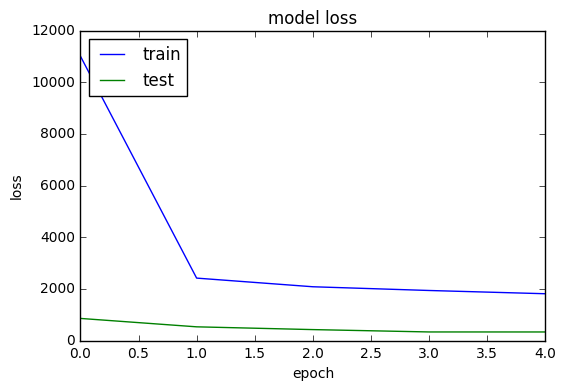

In [20]:
def trainNetForData(Datapath,Labelpath,node_size,layer_num,train_type,problem):
    PD_Data = ReadData(Datapath)
    PD_Label = ReadData(Labelpath)
    Full_Data=PD_Data.as_matrix()
    Full_Label=PD_Label.as_matrix()
    indecs=np.random.permutation(len(Full_Data))
    Full_Data=Full_Data[indecs]
    Full_Label=Full_Label[indecs]
    m_data,n_data=Full_Data.shape
    m_label,n_label=Full_Label.shape
    inPutFiles(PD_Data,PD_Label,n_data,n_label,'D',layer_num+1,problem,train_type)#Could be Delta
    Train_Data = Full_Data[:int(m_data*0.9)]
    Train_Label = Full_Label[:int(m_data*0.9)]
    Test_Data = Full_Data[int(m_data*0.9):]
    Test_Label = Full_Label[int(m_data*0.9):]    
    DNN=FullyConnectedDeepNet(n_data,node_size,n_label,layer_num,0.1)
    mean_DNN,std_DNN=DNN.Train(Train_Data, Train_Label,5,True)
    DNN.ShowHistory()
    writeNormInfo(PD_Data,mean_DNN,std_DNN,problem)
    Topo=NetTopology(DNN.GetModel().layers,True, mean_DNN, std_DNN,train_type)
    Topo.NetTransform('D',True, "Network_RDDL_"+problem+".txt",True)
    mean_Matrix,std_Matrix=Interm_Distribution(DNN.GetModel().layers,Train_Data)
    write_Interm_Ditribution(mean_Matrix,std_Matrix,'Interm_Distribution_RDDL_'+problem+'.txt','D')

Datapath="Inventory_Data.txt"
Labelpath="Inventory_Label.txt"
trainNetForData(Datapath,Labelpath,32,4,'regular','Inventory')